**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/aloiswirth/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
print(sys.version_info)
print(sys.version)
print(tf.__version__)
print(sklearn.__version__)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
2.2.0
0.22.2.post1


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [0]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [6]:
y_pred

array([1])

In [7]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
print(" a = ", a, " b= ", b)

 a =  -0.6363636363636362  b=  [1.81818182]


Saving figure perceptron_iris_plot


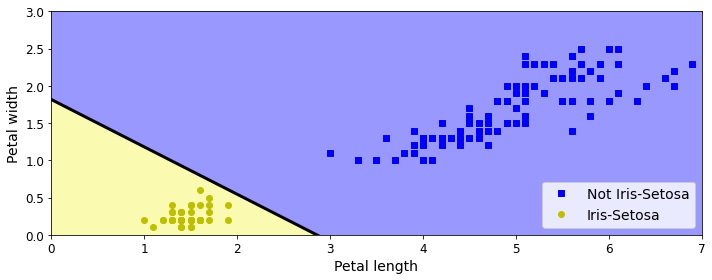

In [9]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 7, 0, 3]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


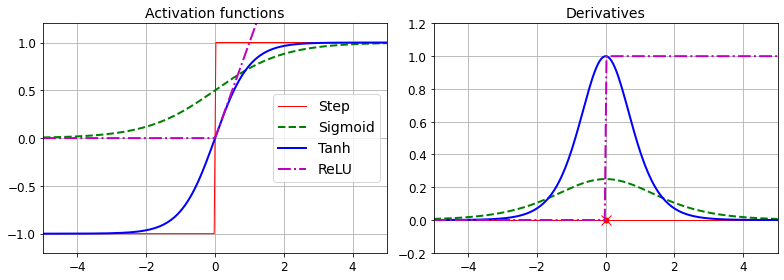

In [11]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [0]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

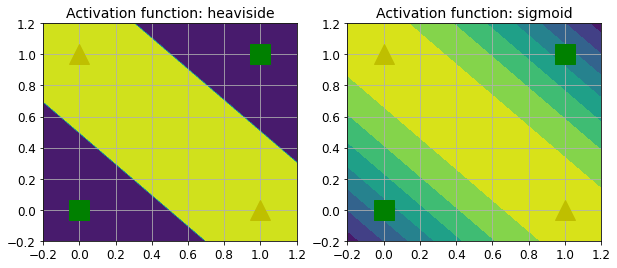

In [13]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
tf.__version__

'2.0.0-dev20190606'

In [0]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [0]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [0]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [0]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

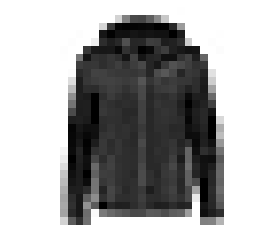

In [0]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [0]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [0]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [0]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [0]:
X_valid.shape

(5000, 28, 28)

In [0]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


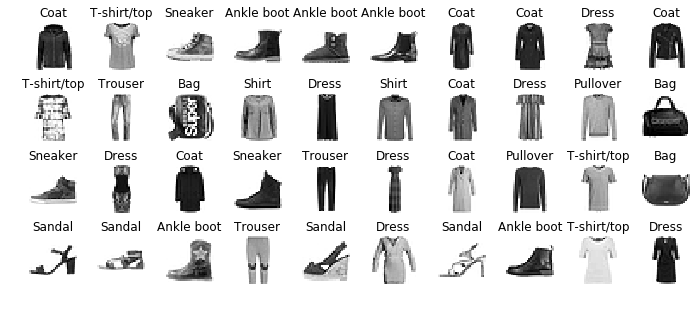

In [0]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.layers

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


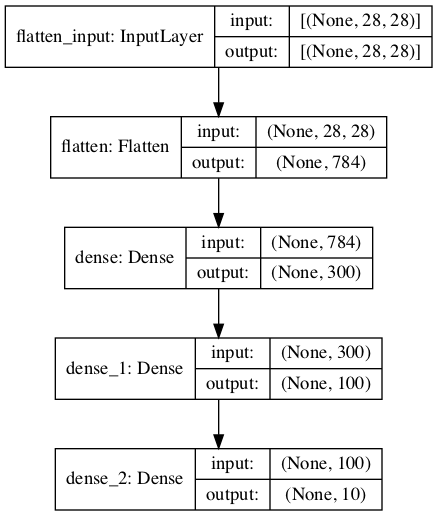

In [0]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [0]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [0]:
model.get_layer(hidden1.name) is hidden1

True

In [0]:
weights, biases = hidden1.get_weights()

In [0]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [0]:
weights.shape

(784, 300)

In [0]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
biases.shape

(300,)

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [0]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

W0611 09:32:55.423388 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 62us/sample - loss: 0.7217 - accuracy: 0.7661 - val_loss: 0.4972 - val_accuracy: 0.8366
Epoch 2/30
55000/55000 [==============================] - 3s 51us/sample - loss: 0.4839 - accuracy: 0.8323 - val_loss: 0.4459 - val_accuracy: 0.8482
Epoch 3/30
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4392 - accuracy: 0.8471 - val_loss: 0.4035 - val_accuracy: 0.8648
Epoch 4/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.4131 - accuracy: 0.8546 - val_loss: 0.3964 - val_accuracy: 0.8638
Epoch 5/30
55000/55000 [==============================] - 3s 51us/sample - loss: 0.3923 - accuracy: 0.8632 - val_loss: 0.3740 - val_accuracy: 0.8700
Epoch 6/30
55000/55000 [==============================] - 3s 50us/sample - loss: 0.3768 - accuracy: 0.8668 - val_loss: 0.3709 - val_accuracy: 0.8702
Epoch 7/30
55000/55000 [==============================] -

In [0]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': None,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [0]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


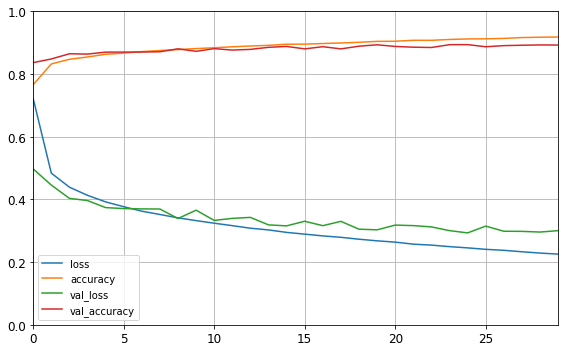

In [0]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [0]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.3343 - accuracy: 0.8857


[0.33426858170032503, 0.8857]

In [0]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [0]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [0]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [0]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


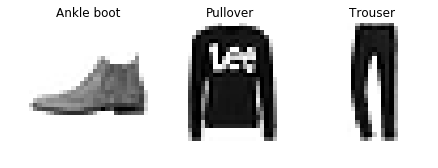

In [0]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 0s 39us/sample - loss: 1.6343 - val_loss: 0.9361
Epoch 2/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.7053 - val_loss: 0.6556
Epoch 3/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6343 - val_loss: 0.6028
Epoch 4/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5974 - val_loss: 0.5631
Epoch 5/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5701 - val_loss: 0.5375
Epoch 6/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5474 - val_loss: 0.5165
Epoch 7/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5283 - val_loss: 0.5072
Epoch 8/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5130 - val_loss: 0.4806
Epoch 9/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4989 - val_l

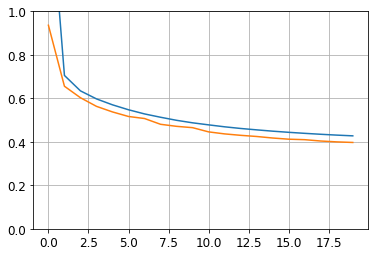

In [0]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [0]:
y_pred

array([[0.3874537],
       [1.6820507],
       [3.0960474]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 30)           270         input_3[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 30)           930         dense_25[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 38)           0           input_3[0][0]                    
                                                                 dense_26[0][0]             

In [0]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 0s 43us/sample - loss: 1.2544 - val_loss: 2.9415
Epoch 2/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6531 - val_loss: 0.8754
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5873 - val_loss: 0.5529
Epoch 4/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5574 - val_loss: 0.5205
Epoch 5/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5343 - val_loss: 0.5399
Epoch 6/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5160 - val_loss: 0.4793
Epoch 7/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5004 - val_loss: 0.4655
Epoch 8/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4873 - val_loss: 0.4820
Epoch 9/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4761 - val_l

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 45us/sample - loss: 1.8070 - val_loss: 0.8422
Epoch 2/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6752 - val_loss: 0.6426
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5969 - val_loss: 0.5829
Epoch 4/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5580 - val_loss: 0.5259
Epoch 5/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5317 - val_loss: 0.5005
Epoch 6/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5125 - val_loss: 0.4792
Epoch 7/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4963 - val_loss: 0.4786
Epoch 8/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4840 - val_loss: 0.4562
Epoch 9/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4733 - val_l

Adding an auxiliary output for regularization:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [0]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [0]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 2.1325 - main_output_loss: 1.9139 - aux_output_loss: 4.0950 - val_loss: 1.6650 - val_main_output_loss: 0.8892 - val_aux_output_loss: 8.6440
Epoch 2/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.8870 - main_output_loss: 0.6930 - aux_output_loss: 2.6303 - val_loss: 1.4991 - val_main_output_loss: 0.6627 - val_aux_output_loss: 9.0235
Epoch 3/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.7421 - main_output_loss: 0.6079 - aux_output_loss: 1.9515 - val_loss: 1.4340 - val_main_output_loss: 0.5748 - val_aux_output_loss: 9.1628
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6766 - main_output_loss: 0.5683 - aux_output_loss: 1.6515 - val_loss: 1.3260 - val_main_output_loss: 0.5579 - val_aux_output_loss: 8.2343
Epoch 5/20
11610/11610 [==============================] - 0s 38us/s

In [0]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 26us/sample - loss: 0.4661 - main_output_loss: 0.4167 - aux_output_loss: 0.9138


# The subclassing API

In [0]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [0]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 61us/sample - loss: 2.2914 - output_1_loss: 2.1790 - output_2_loss: 3.2954 - val_loss: 2.7823 - val_output_1_loss: 2.0246 - val_output_2_loss: 9.5935
Epoch 2/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.9834 - output_1_loss: 0.8678 - output_2_loss: 2.0207 - val_loss: 1.6646 - val_output_1_loss: 0.7720 - val_output_2_loss: 9.6933
Epoch 3/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.8264 - output_1_loss: 0.7295 - output_2_loss: 1.6967 - val_loss: 1.4471 - val_output_1_loss: 0.6947 - val_output_2_loss: 8.2170
Epoch 4/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.7616 - output_1_loss: 0.6750 - output_2_loss: 1.5418 - val_loss: 1.2658 - val_output_1_loss: 0.6379 - val_output_2_loss: 6.9130
Epoch 5/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.7203 - output_1_loss: 0.

In [0]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 41us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4578 - val_l

In [0]:
model.save("my_keras_model.h5")

In [0]:
model = keras.models.load_model("my_keras_model.h5")

In [0]:
model.predict(X_new)

array([[0.5492519],
       [1.674789 ],
       [3.0483952]], dtype=float32)

In [0]:
model.save_weights("my_keras_weights.ckpt")

In [0]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 49us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4578 - val_l

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.4483 - val_loss: 0.4280
Epoch 2/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4393 - val_loss: 0.4106
Epoch 3/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4319 - val_loss: 0.4078
Epoch 4/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4262 - val_loss: 0.4037
Epoch 5/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4205 - val_loss: 0.3956
Epoch 6/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4160 - val_loss: 0.3894
Epoch 7/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4116 - val_loss: 0.3891
Epoch 8/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4077 - val_loss: 0.3817
Epoch 9/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.404

In [0]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [0]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10144/11610 [=========================>....] - ETA: 0s - loss: 0.3427
val/train: 0.98
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3467 - val_loss: 0.3384


# TensorBoard

In [0]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [0]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2019_06_08-11_37_24'

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [0]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 45us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4578 - val_l

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [0]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [0]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2019_06_08-11_38_07'

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [0]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5259 - val_loss: 0.4834
Epoch 2/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4069 - val_loss: 0.3912
Epoch 3/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3744 - val_loss: 7.5517
Epoch 4/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3656 - val_loss: 1.1554
Epoch 5/30
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3524 - val_loss: 0.4531
Epoch 6/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3455 - val_loss: 0.3197
Epoch 7/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3355 - val_loss: 0.3217
Epoch 8/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3326 - val_loss: 0.3118
Epoch 9/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3219 - val_l

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [0]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [0]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [0]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 41us/sample - loss: 1.0910 - val_loss: 21.1892
Epoch 2/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.7607 - val_loss: 4.8909
Epoch 3/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5401 - val_loss: 0.5721
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4752 - val_loss: 0.4433
Epoch 5/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4499 - val_loss: 0.4270
Epoch 6/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4348 - val_loss: 0.4165
Epoch 7/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4240 - val_loss: 0.4060
Epoch 8/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4166 - val_loss: 0.4030
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.41

In [0]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3504


In [0]:
y_pred = keras_reg.predict(X_new)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 0s 43us/sample - loss: 3.5539 - val_loss: 1.8522
Epoch 2/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.3322 - val_loss: 1.0094
Epoch 3/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8593 - val_loss: 0.7356
Epoch 4/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7338 - val_loss: 0.6880
Epoch 5/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6915 - val_loss: 0.8475
Epoch 6/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6710 - val_loss: 0.6480
Epoch 7/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6507 - val_loss: 0.8315
Epoch 8/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6384 - val_loss: 0.8030
Epoch 9/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6268 - val_loss: 0.6048
Epoch 10/100
7740/7740 [==============================] - 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x12e9e6588>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12e9a1048>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [0]:
rnd_search_cv.best_score_

-0.3500674913429577

In [0]:
rnd_search_cv.best_estimator_

In [0]:
rnd_search_cv.score(X_test, y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.3159


-0.31594527869723565

In [0]:
model = rnd_search_cv.best_estimator_.model
model

In [0]:
model.evaluate(X_test, y_test)

5160/5160==============================] - 0s 22us/sample - loss: 0.3252


0.3251738954422086

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

TODO